<h2 align=center> Building a Text Matching System for Question Matching </h2>

<h4 align=center> APPLIED NATURAL LANGUAGE PROCESSING</h4>



### Note: After running the whole notebook,
#### 1. For TFIDF Model, to get top matches (2 or 5), use code:
- top5 = get_similarity_tfidf("sentence",5) 
- print_top_k(top5)

#### 2. For Average word Model, use code:
- top5 = get_similarity_avg_word("sentence" , 5 )
- print_top_k(top5)

#### 3. For Smooth Inverse Frequency  Model, use code:
- top5 = get_similarity_SIF("sentence" , 5 )
- print_top_k(top5)

##  Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import sklearn
import operator
import sys
from sklearn.model_selection import train_test_split

import nltk
from nltk import stem 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import random
import re
import math
from math import sqrt
from math import log
from math import log10
from statistics import mean
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

import collections
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
import itertools
from itertools import islice
from itertools import chain
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
# string operations
import string 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# nltk downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load and Explore the Data

In [3]:
# data loading
data = pd.read_csv('data.tsv', sep='\t',error_bad_lines=False)
data.head(10) 

b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0
5,119056,193387,193388.0,How not to feel guilty since I am Muslim and I...,"I don't beleive I am bulimic, but I force thro...",0.0
6,356863,422862,96457.0,How is air traffic controlled?,How do you become an air traffic controller?,0.0
7,106969,147570,787.0,What is the best self help book you have read?...,What are the top self help books I should read?,1.0
8,196763,297539,297540.0,Can I enter University of Melbourne if I could...,University of the Philippines: If I take a sec...,0.0
9,256389,37932,371478.0,Do you need a passport to go to Jamaica from t...,How can I move to Jamaica?,0.0


### Observation - 
- Seems like there are some abnormality in the data due to which it is not able to load 3 rows, since its not too many data point we can skip them

#### Checking for null values in question1 and question2

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363192 entries, 0 to 363191
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            363192 non-null  object 
 1   qid1          363192 non-null  object 
 2   qid2          363185 non-null  float64
 3   question1     363181 non-null  object 
 4   question2     363180 non-null  object 
 5   is_duplicate  363180 non-null  float64
dtypes: float64(2), object(4)
memory usage: 16.6+ MB


In [5]:
# change data types
data["id"] = pd.to_numeric(data["id"],errors='coerce')
data["qid1"] = pd.to_numeric(data["qid1"],errors='coerce') 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363192 entries, 0 to 363191
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            363182 non-null  float64
 1   qid1          363189 non-null  float64
 2   qid2          363185 non-null  float64
 3   question1     363181 non-null  object 
 4   question2     363180 non-null  object 
 5   is_duplicate  363180 non-null  float64
dtypes: float64(4), object(2)
memory usage: 16.6+ MB


In [7]:
# check unique values
data.nunique()

id              363182
qid1            266111
qid2            273126
question1       265929
question2       272961
is_duplicate         2
dtype: int64

In [8]:
data.shape

(363192, 6)

In [10]:
# Check for null values in all columns
tr_null = data.isnull().sum()
print("Null values in set: ")
print(tr_null)
print()

Null values in set: 
id              10
qid1             3
qid2             7
question1       11
question2       12
is_duplicate    12
dtype: int64



In [11]:
# dropping all null values
data = data.dropna()
data.shape

(363177, 6)

In [12]:
Q1duplicateRows = data[data.duplicated([ 'question1'])]
print(Q1duplicateRows.shape)

Q2duplicateRows = data[data.duplicated([ 'question2'])]
print(Q2duplicateRows.shape)

(97251, 6)
(90218, 6)


In [13]:
# dropping rows with duplicated questions

data = data.drop_duplicates(subset = ['question1'], keep = 'last').reset_index(drop = True)
print("After dropping duplicated rows from question-1 column, the shape of dataframe is : ", data.shape)

data = data.drop_duplicates(subset = ['question2'], keep = 'last').reset_index(drop = True)
print("After dropping duplicated rows from question-2 column, the shape of dataframe is : ", data.shape) 

After dropping duplicated rows from question-1 column, the shape of dataframe is :  (265926, 6)
After dropping duplicated rows from question-2 column, the shape of dataframe is :  (232203, 6)


In [14]:
# label distribution in the data
data['is_duplicate'].value_counts()

0.0    169095
1.0     63108
Name: is_duplicate, dtype: int64

In [16]:
# Check for null values
null_tr = data.isnull().sum()
print("Null values in set: ")
print(null_tr)
print()

Null values in set: 
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64



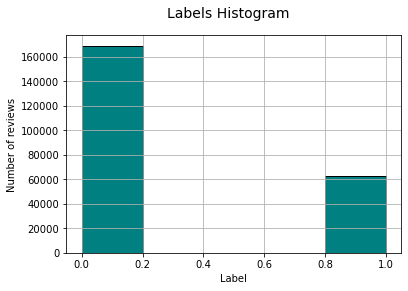

In [17]:
# plot distribution of label
data['is_duplicate'].hist(edgecolor = 'black',bins=5,facecolor = 'teal')
plt.suptitle("Labels Histogram",size = 14)
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.show()

#### Creating a test dataframe

In [18]:
allduplicate_df = data[data['is_duplicate'] == 1]
df_test = allduplicate_df[0:100] 
df_test

,id,qid1,qid2,question1,question2,is_duplicate
1,402555.0,536040.0,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
6,11568.0,22332.0,22333.0,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?,1.0
11,33995.0,62359.0,62360.0,How does an IQ test work and what is determine...,How does IQ test works?,1.0
12,244506.0,357159.0,357160.0,Is it safe to use Xiaomi mobile phones?,Is it safe or unsafe to use Xiaomi Products?,1.0
14,375073.0,506056.0,506057.0,What are the best books on cosmology?,Which is the best book for cosmology?,1.0
...,...,...,...,...,...,...
379,17002.0,32363.0,32364.0,What is it like to work at Factual?,What is it like to work at Factual in 2016?,1.0
385,179873.0,275905.0,275906.0,How do I recover data from an external hard disk?,How can I recover data from an external hard d...,1.0
390,236758.0,347752.0,347753.0,What is the perfect website that lists all for...,What is the perfect website that lists all typ...,1.0
392,72098.0,123946.0,123947.0,Can I install Mac OS on my Dell laptop? How?,How do I install Mac OS on a Dell laptop?,1.0


In [19]:
list_ques1  = df_test['question1'].tolist()

print("Length of question 1 list(first 100 with is_dup = 1): ", len(list_ques1))
print("Unique question 1 Ids: ", df_test['qid1'].nunique()) # all unique ids

Length of question 1 list(first 100 with is_dup = 1):  100
Unique question 1 Ids:  100


### Reusing the functions for wordcloud, n-grams, preprocessing from Assignment-1 and an old project of mine

In [20]:
def wordcloud_display(text_data, title):

    # Taking all unique data and storing it in a list
    words_list = text_data.unique().tolist()
    # Joining all these words togather to into wordcloud function
    words = ' '.join(words_list)
    
    # To create a collage of words form input
    wordcloud = WordCloud(width = 800, height = 400,
                      stopwords = set(STOPWORDS)).generate(words)

    plt.figure(figsize=(20, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(f'Words in {title}')
    plt.axis("off")
    plt.show()

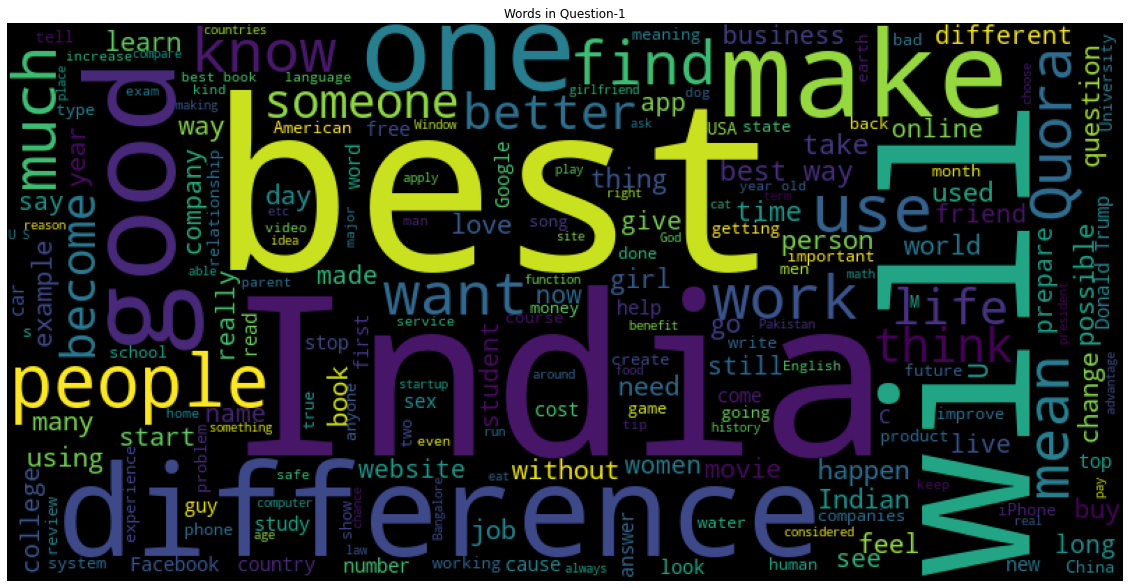

In [21]:
# Wordcloud for Question-1
wordcloud_display(data['question1'], 'Question-1')

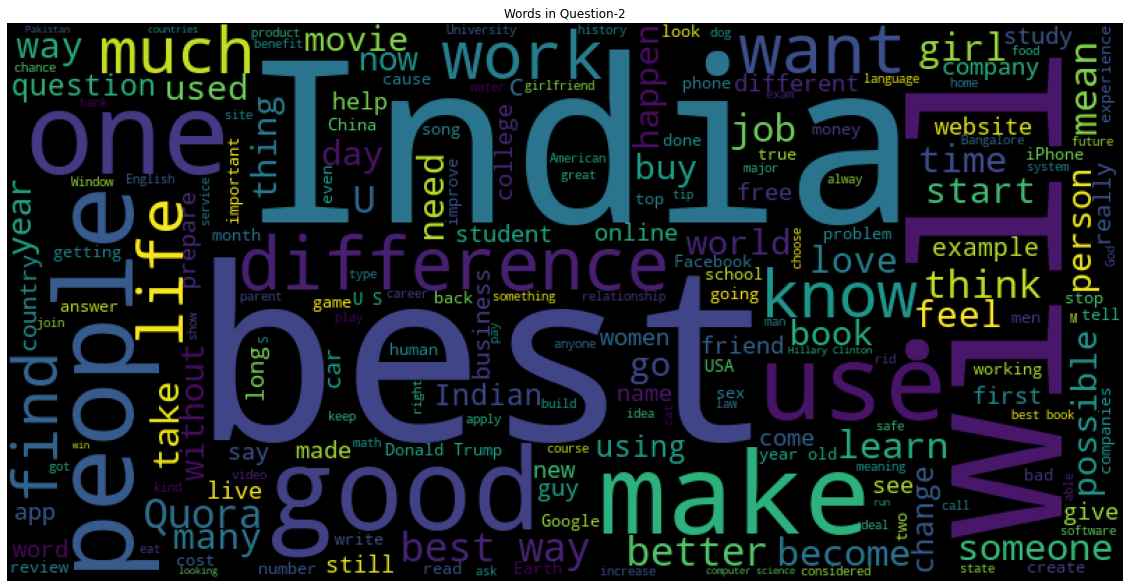

In [22]:
# Wordcloud for Question-1
wordcloud_display(data['question2'], 'Question-2')

In [23]:
def word_freq_plot(data, title, bar_color):
    
    # taking only 25 most used words 
    frequent_words = Counter(data).most_common(25)
    # Storing these words and their counts in a data frame and sorting these values based on their count
    df_words = pd.DataFrame(frequent_words, columns=['word', 'count']).sort_values('count')

    # Plotting a bar graph based on the data
    plt.barh(df_words['word'].values, df_words['count'].values, orientation='horizontal', color=bar_color) # plot
    plt.title(f'Top words in {title}')

In [24]:
# Function to retrieve single words from question text
def get_unigrams(data):
    unigrams = []
    
    # Running a loop to separate/split the question text into single words and filtering stopwords
    for words in data:
        unigrams.extend([w for w in words.lower().split() if w not in STOPWORDS])
    return unigrams

# Function to retrieve pairs of 2 words from question text
def get_bigrams(data):
    bigrams = []
    
    # Running a loop to separate/split the question text into 2 words and filtering stopwords
    for words in data:
        words = [w for w in words.lower().split() if w not in STOPWORDS]
        bi = [b for b in nltk.bigrams(words)]
        bi = [' '.join(w) for w in bi]
        bigrams.extend(bi)
    return bigrams

# Function to retrieve pairs of 3 words from question text
def get_trigrams(data):
    trigrams = []
    
    # Running a loop to separate/split the question text into 3 words and filtering stopwords
    for words in data:
        words = [w for w in words.lower().split() if w not in STOPWORDS]
        tri = [t for t in nltk.trigrams(words)]
        tri = [' '.join(w) for w in tri]
        trigrams.extend(tri)
    return trigrams

In [25]:
# Creating data frames of unigram, bigram, trigram with question-1 and question-2

# Unigrams
unigrams_positive  = get_unigrams(data['question1'])
unigrams_negative = get_unigrams(data['question2'])

# Bigrams
bigrams_positive = get_bigrams(data['question1'])
bigrams_negative = get_bigrams(data['question2'])

# Trigrams
trigrams_positive = get_trigrams(data['question1'])
trigrams_negative = get_trigrams(data['question2'])

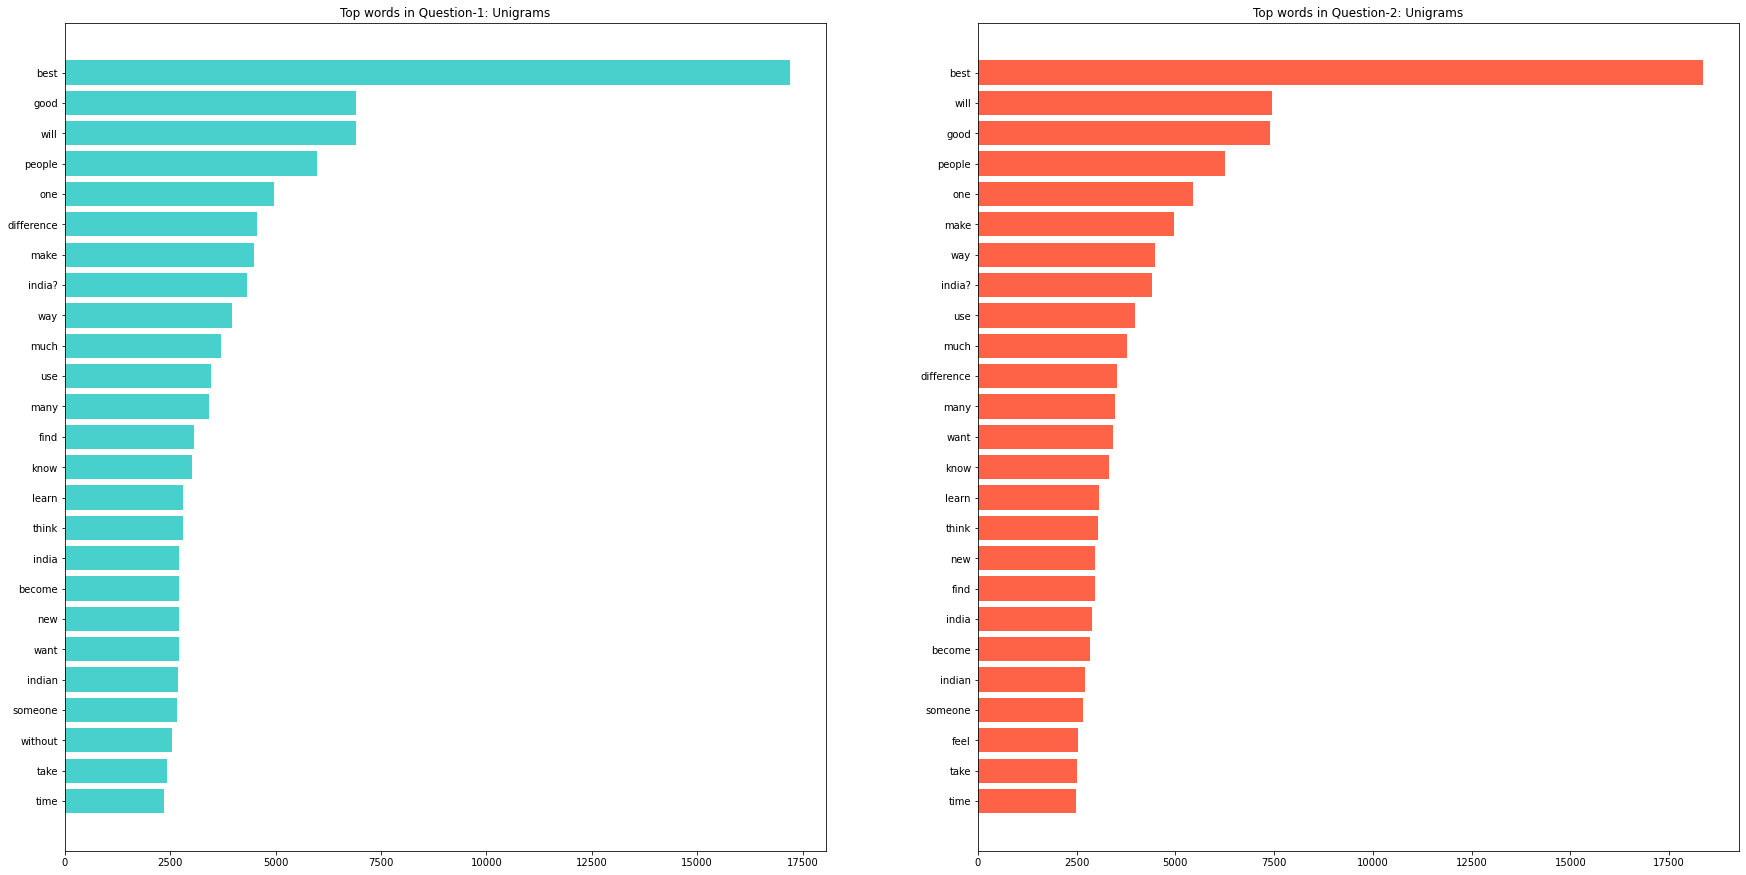

In [26]:
# plotting graph of Unigrams Sincere words 
plt.subplot(1, 2, 1)
word_freq_plot(unigrams_positive, 'Question-1: Unigrams', 'mediumturquoise')

# plotting graph of Unigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(unigrams_negative, 'Question-2: Unigrams', 'tomato')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

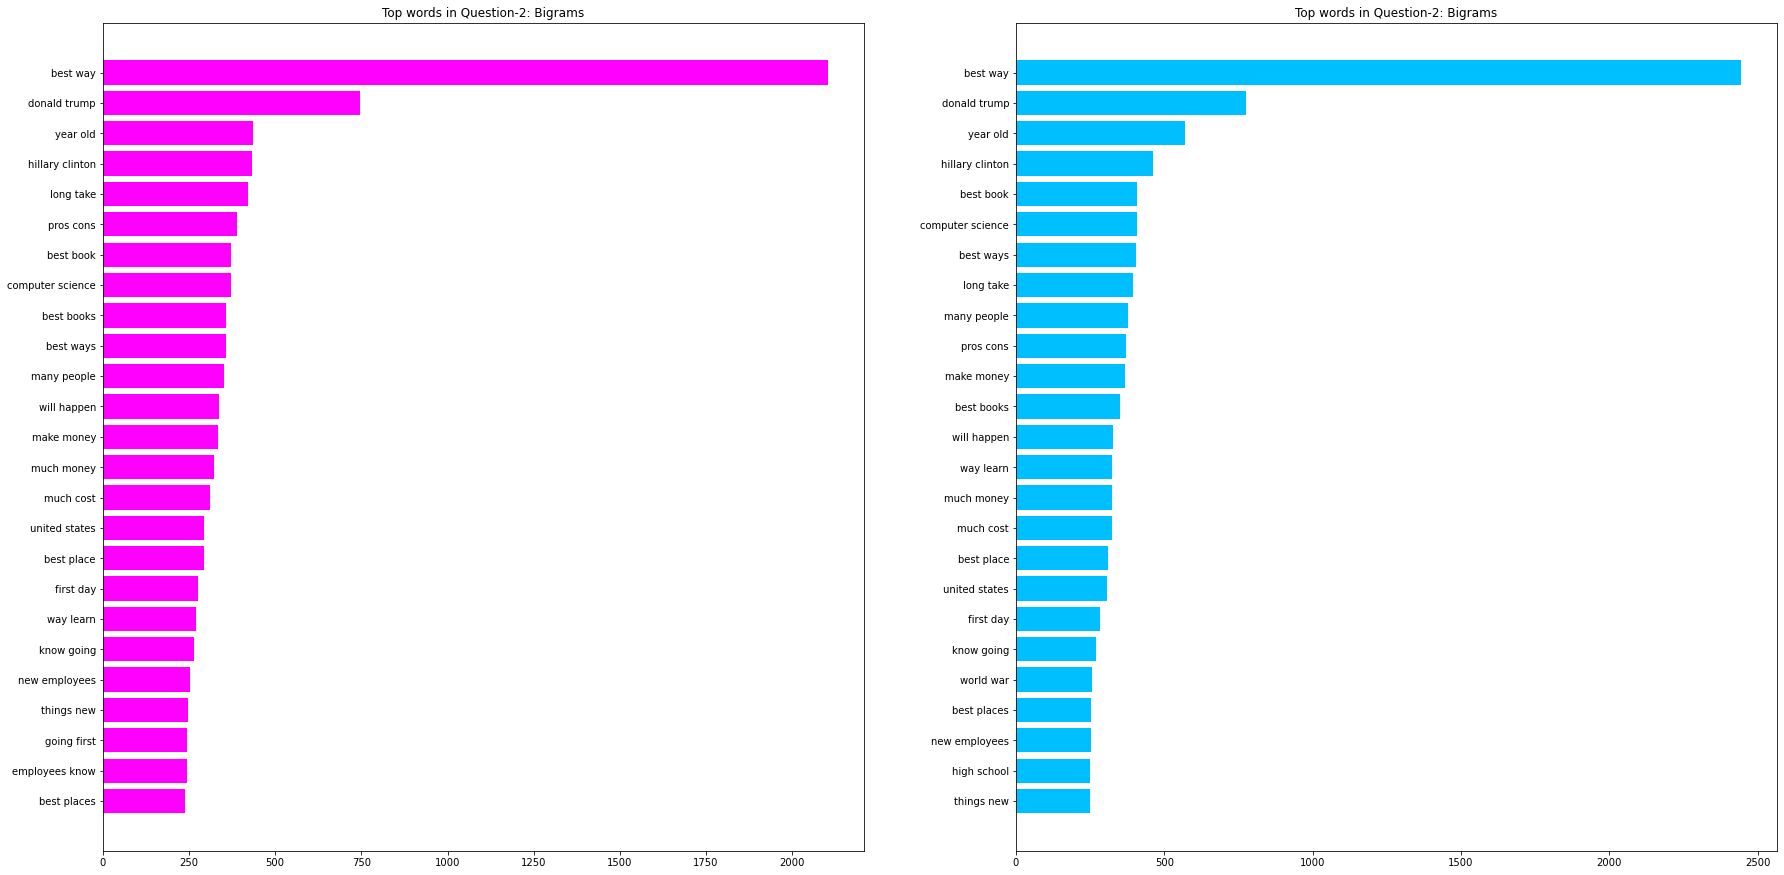

In [27]:
# plotting graph of Bigrams Sincere words
plt.subplot(1, 2, 1)
word_freq_plot(bigrams_positive, 'Question-2: Bigrams', 'magenta')

# plotting graph of Bigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(bigrams_negative, 'Question-2: Bigrams', 'deepskyblue')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

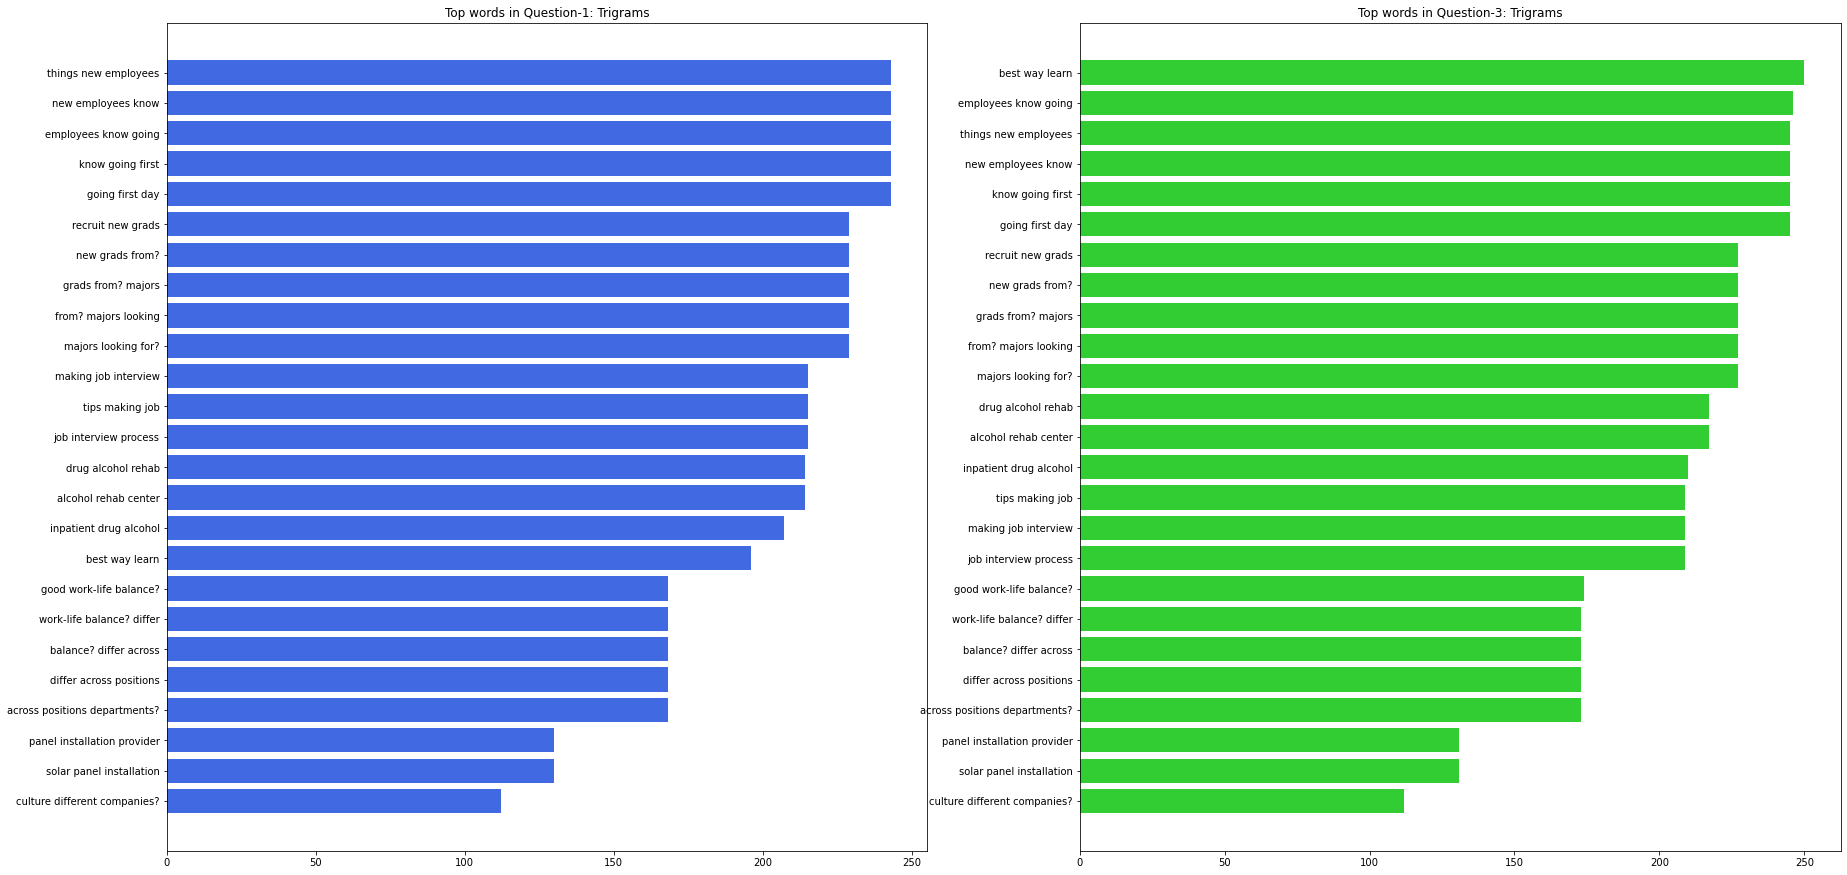

In [28]:
# plotting graph of Trigrams Sincere words
plt.subplot(1, 2, 1)
word_freq_plot(trigrams_positive, 'Question-1: Trigrams', 'royalblue')

# plotting graph of Trigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(trigrams_negative, 'Question-3: Trigrams', 'limegreen')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

## Data Prepocessing :

Based on the EDA section, we discovered through n-gram plots and wordcloud that the dataset contains a lot of undesirable characters and words. As a result, a direct input of this dataset into our model would not produce good results. So, in order to clean up our data, we must perform some preprocessing.

We will eliminate unnecessary elements from our reviews in this step. We do not want the following in our input:

- Stopwords
- Punctuation
- Numbers
- HTML tags

<b> Step 1: Changing all upper case to lower case 

In [31]:
data['question1_lower'] = data['question1'].str.lower()
data['question2_lower'] = data['question2'].str.lower()
data[['question1','question1_lower','question2','question2_lower']].head(10)

,question1,question1_lower,question2,question2_lower
0,How is the life of a math student? Could you d...,how is the life of a math student? could you d...,Which level of prepration is enough for the ex...,which level of prepration is enough for the ex...
1,How do I control my horny emotions?,how do i control my horny emotions?,How do you control your horniness?,how do you control your horniness?
2,Where can I find a power outlet for my laptop ...,where can i find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...","would a second airport in sydney, australia be..."
3,How not to feel guilty since I am Muslim and I...,how not to feel guilty since i am muslim and i...,"I don't beleive I am bulimic, but I force thro...","i don't beleive i am bulimic, but i force thro..."
4,How is air traffic controlled?,how is air traffic controlled?,How do you become an air traffic controller?,how do you become an air traffic controller?
5,What is the responsibility of SAP ERP key user?,what is the responsibility of sap erp key user?,What is a qualified SAP ERP key user?,what is a qualified sap erp key user?
6,Which is the best book to study TENSOR for gen...,which is the best book to study tensor for gen...,Which is the best book for tensor calculus?,which is the best book for tensor calculus?
7,"If you received a check from Donald Knuth, wha...","if you received a check from donald knuth, wha...",How can I contact Donald Knuth?,how can i contact donald knuth?
8,"If a die is rolled, what is the probability th...","if a die is rolled, what is the probability th...",If a die is rolled. what is the probability th...,if a die is rolled. what is the probability th...
9,Whether alloy are only isotropic and homogeneo...,whether alloy are only isotropic and homogeneo...,What is the best backend for my app?,what is the best backend for my app?


<b> Step 2: Removing punctuation, numbers, HTML and stopwords </b>

In [32]:
stop_words = stopwords.words('english')

print(f'Stopwords examples: {stop_words[0:10]}')
print(f'Total stopwords in english language: {len(stop_words)}')

Stopwords examples: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Total stopwords in english language: 179


In [33]:
print(f'Punctuation {string.punctuation}')

Punctuation !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [34]:
# Function to remove HTML, numbers, Stopwords, Punctuation
def text_transform(string_1):
    
    # remove html
    html=re.compile(r'<.*?>')
    string_1 = html.sub(r'',string_1)
    
    # remove numbers
    string_1 = re.sub(r'\d+', '', string_1)
    
    # remove punctuation
    # remove stopwords
    tokens = nltk.word_tokenize(string_1)
    
    new_string = []
    for word in tokens:
        # remove words with len = 2 AND stopwords
        if len(word) > 2 and word not in stop_words:
            new_string.append(word)
    
    
    
    string_1 = ' '.join(new_string)
    string_1 = string_1.strip()

    exclude = set(string.punctuation)
    string_1 = ''.join(ch for ch in string_1 if ch not in exclude)
    
    return string_1.strip()

In [35]:
# Example how above function will transform our review text

text_transform('there is a dog near <br/> the tree 123! look')

'dog near tree look'

In [36]:
data['question1_transformed'] = data['question1_lower'].apply(text_transform)
data['question2_transformed'] = data['question2_lower'].apply(text_transform)
data[['question1','question1_lower', 'question1_transformed','question2', 'question2_lower','question2_transformed']].head()

,question1,question1_lower,question1_transformed,question2,question2_lower,question2_transformed
0,How is the life of a math student? Could you d...,how is the life of a math student? could you d...,life math student could describe experiences,Which level of prepration is enough for the ex...,which level of prepration is enough for the ex...,level prepration enough exam jlpt
1,How do I control my horny emotions?,how do i control my horny emotions?,control horny emotions,How do you control your horniness?,how do you control your horniness?,control horniness
2,Where can I find a power outlet for my laptop ...,where can i find a power outlet for my laptop ...,find power outlet laptop melbourne airport,"Would a second airport in Sydney, Australia be...","would a second airport in sydney, australia be...",would second airport sydney australia needed h...
3,How not to feel guilty since I am Muslim and I...,how not to feel guilty since i am muslim and i...,feel guilty since muslim conscious nt sex toge...,"I don't beleive I am bulimic, but I force thro...","i don't beleive i am bulimic, but i force thro...",nt beleive bulimic force throw atleast day eat...
4,How is air traffic controlled?,how is air traffic controlled?,air traffic controlled,How do you become an air traffic controller?,how do you become an air traffic controller?,become air traffic controller


<b> Step 3: Lemmatization</b>

<b>Lematization</b> : We attempt to simplify a term down to its most basic form. When a word is lemmatized, the root word is referred to as the lemma. The algorithms are aware of the language's definitions of words.


In [37]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

# Example of Lemmatizing a word
print(lemmatizer.lemmatize("rocks", pos="v"))
print(lemmatizer.lemmatize("gone", pos="v"))

rock
go


In [38]:
def lemmatizer_text(s):
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        lem = lemmatizer.lemmatize(w, pos="v")
        # exclude if lenght of lemma is smaller than 2
        if len(lem) > 2:
            new_string.append(lem)
    
    s = ' '.join(new_string)
    return s.strip()

In [39]:
data['question1_lemma'] = data['question1_transformed'].apply(lemmatizer_text)
data['question2_lemma'] = data['question2_transformed'].apply(lemmatizer_text)
data[['question1_lemma','question2_lemma']].head(20)

,question1_lemma,question2_lemma
0,life math student could describe experience,level prepration enough exam jlpt
1,control horny emotions,control horniness
2,find power outlet laptop melbourne airport,would second airport sydney australia need hig...
3,feel guilty since muslim conscious sex together,beleive bulimic force throw atleast day eat so...
4,air traffic control,become air traffic controller
5,responsibility sap erp key user,qualify sap erp key user
6,best book study tensor general relativity basic,best book tensor calculus
7,receive check donald knuth get,contact donald knuth
8,die roll probability number greater,die roll probability number top
9,whether alloy isotropic homogeneous like metal...,best backend app


In [29]:
# function to remove puntuation
def remove_puntuation(text):
    text = [word for word in text if word.isalpha()] #  remove all puntuation and numbers
    return text 

# function to remove stop word from text
def remove_stopwords(text):
    stop_words = list(stopwords.words('english')) # store nltk stopwords
    text = [word for word in text if not word in stop_words] 
    return text 

# function to perform stemming
def stemming(text):
    stemer = stem.porter.PorterStemmer()
    text = [stemer.stem(token) for token in text] 
    return text 

# function to perform lemmatization
def lemmatization (text):
    lemmatizer = stem.WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(token) for token in text]
    return text 


# function to perform text preprocessing (lemmatization and no stemming)
def clean_corpus(text):
    
    text = text.lower()                # lower case  
    token = word_tokenize(text)         # tokenise
  
    token = remove_stopwords(token)    # remove stopwords
    token = remove_puntuation(token)   # remove puntuation 
    token = lemmatization(token)       # lemmatize

    all_tokens = " ".join(token)       # join all tokens

    return all_tokens

In [41]:
# function to determine a dataset's word count 
def word_count(data):
    
    words_unique = [] 
    
    for row in data:
        for word in row.split(" "):
            if len(word) > 2 and word not in words_unique:
                words_unique.append(word) # Add each unique word of length > 2 to the list
            
    words_unique.sort()
    vocab = {j:i for i,j in enumerate(words_unique)} # Enumerate the list, i.e., give consecutive numbers to each item, store in a dict
    return vocab

In [42]:
#total number of unique words in question2 and question1 with length of word > 2
ques2_unique_words = word_count(data['question2_lemma'])
ques1_unique_words = word_count(data['question1_lemma'])
print("Number of unique words in question2: ",len(ques2_unique_words))
print("Number of unique words in question1: ",len(ques1_unique_words))

Number of unique words in question2:  53365
Number of unique words in question1:  59096


In [43]:
# function to remove words which have a count less than N
def min_df(col , N):
    v = col.str.split().tolist()              # split words into list
    c = Counter(chain.from_iterable(v))       # compute word frequency
    col = [' '.join([j for j in i if c[j] > N]) for i in v] #  join and reassign      
    return col

# function to remove words which have a count greater than N
def max_df(col , N):
    v = col.str.split().tolist()             # split words into list
    c = Counter(chain.from_iterable(v))      # compute word frequency
    col = [' '.join([j for j in i if c[j] < N]) for i in v] #  join and reassign      
    return col

In [46]:
data["processed_ques2"] = max_df(data["question2_lemma"], 5000)  #remove words with count greater than 5k
data["processed_ques2"] = min_df(data["question2_lemma"], 1) 

#total number of unique words in question2 after preprocessing
ques2_unique_words = word_count(data['processed_ques2'])
print("Number of unique words in question2: ",len(ques2_unique_words))   #15479

Number of unique words in question2:  25817


In [48]:
data['processed_ques2'][0:20]

0                     level prepration enough exam jlpt
1                                               control
2     would second airport sydney australia need hig...
3     bulimic force throw atleast day eat something ...
4                         become air traffic controller
5                              qualify sap erp key user
6                             best book tensor calculus
7                                  contact donald knuth
8                       die roll probability number top
9                                      best backend app
10     type government france currently benefit country
11                                            test work
12                      safe unsafe use xiaomi products
13                creative ideas arrange freshers party
14                                  best book cosmology
15                          people staten island racist
16                         beautiful house around world
17                                              

In [49]:
list_ques2 = data['processed_ques2'].tolist()
len(list_ques2)

232203

In [50]:
# remove empty questions 
count = 0
i = 0

for line in list_ques2: 
    if line == "":
        count = count+ 1
    del list_ques2[i] # delete questions which are empty strings  
    
    i = i +1

print("Total number of empty questions in question2: ",count)
len(list_ques2)

Total number of empty questions in question2:  266


116101

## 1. TF IDF

In [51]:
vocab = word_count(data['question2_lemma'][:50000]) 
print("Vocabulary length of precessed question2 column: ",len(vocab))  #17899

Vocabulary length of precessed question2 column:  25082


In [52]:
# function to calculate Inverse document frequesny
def doc_freq_get(ques_data,word):
    
    frequency = 0
    for row in ques_data:
        if word in row:
            frequency = frequency + 1
    return frequency

# function to generate TF-IDF matrix
def transform_data(ques_data, vocab):
    
    rows = []              # Records the row number/question the word belongs to
    word_freq_each = []   # stores the frequency of a word in the vocabulary 
    value_tf_idf = []           # records tf_idf value of the word
    
    for indx, row in enumerate(ques_data): # for each Qeuestion 2 in the dataset

        sentence_word_freq = dict(Counter(row.split())) 

        for word, frequency in sentence_word_freq.items(): 
            if len(word) < 2:                     # keep words with length > 2
                continue 

            idx_vocab = vocab.get(word, -1)      # if the word doesn't exist, return -1. get the frequency of a word in the vocabulary.
            
            if idx_vocab != -1:

                rows.append(indx)   
                word_freq_each.append(idx_vocab)

                doc_freq = doc_freq_get(ques_data,word) # document frequency of a word
           
                TF = frequency / len(row.split())        # term frequency
                IDF = log10(len(ques_data)/doc_freq)     # inverse document frequency
                
                val = TF * IDF 
                value_tf_idf.append(val)

    x = len(ques_data)
    y = len(vocab)

    # The row index of the TFIDF Matrix is the row number or question that a word fits in, and the column index is the frequency of each word.               
    return csr_matrix( (value_tf_idf, (rows, word_freq_each)), shape=(x,y) ) 

In [101]:
cols_tfidf = [] #keep the term for each column in the TFIDF matrix.  
 
for key, val in vocab.items():
    cols_tfidf.append(key) 

print("TF-IDF columns length is :- ",len(cols_tfidf))


TF-IDF columns length is :-  25082


In [102]:
vect_tfidf = transform_data(list_ques2[0:50000] , vocab) # get TFIDF matrix

print("TF-IDF vector shape: " , str(vect_tfidf.shape))
print("TF_IDF vector representation : ",vect_tfidf)    


TF-IDF vector shape:  (50000, 25082)
TF_IDF vector representation :    (0, 4805)	2.5114492834995557
  (1, 1581)	0.3503519967565238
  (1, 3031)	0.4271790913032744
  (1, 5561)	0.1573594809402161
  (1, 6842)	0.13175296150279248
  (1, 8050)	0.1713384007821908
  (1, 8428)	0.2168275258151696
  (1, 9470)	0.3109287639439264
  (1, 20824)	0.29289534087421426
  (1, 20829)	0.22582965057166554
  (1, 22163)	0.18302075143034138
  (1, 22439)	0.28356240070174626
  (2, 7428)	0.5276544327964814
  (2, 12152)	0.4906914673043738
  (2, 18074)	0.6637517525248826
  (2, 19539)	0.4845016400325549
  (2, 23551)	0.5099501783361279
  (3, 4745)	0.9165266658970352
  (3, 6484)	0.7957387144267548
  (3, 12311)	1.465980002890679
  (4, 1170)	0.4528419631653001
  (4, 1845)	1.1950088840097273
  (4, 2258)	0.37177263193132504
  (5, 22249)	1.0214359011615934
  (5, 24602)	0.7661219743779836
  :	:
  (49995, 7918)	0.676935982160881
  (49995, 8981)	0.8737125054200235
  (49995, 22100)	0.4811132596518673
  (49996, 857)	0.258882877783

In [103]:
array_tfidf = vect_tfidf.toarray()
print("TF_IDF array representation is : ",array_tfidf )
print("Shape of TF-IDF array is ", array_tfidf.shape)

TF_IDF array representation is :  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of TF-IDF array is  (50000, 25082)


In [104]:
# method for creating inverted indexes
def inverted_index(data):

    dict_index_inv = {}

    for index, rows in enumerate(data):
        for word in rows.split():

            if len(word) > 2:                        # discard words of length less than 2
                if word not in dict_index_inv.keys() : 
                    dict_index_inv[word] = [index]      # add word as key in dict

                elif index not in dict_index_inv[word] :
                    dict_index_inv[word].append(index)  # add location of document(question2) as value 

    return dict_index_inv


In [105]:
index_inverted = inverted_index(list_ques2[0:50000])
len(index_inverted)

18576

In [106]:
# find the TFIDF matrix's position for the column that represents the word "term"
def find_pos_term(term):
    position = -99
    for i in [i for i,x in enumerate(cols_tfidf) if x == term]:
        position = i 
    return position

In [107]:
print(find_pos_term("safe"))
print(find_pos_term("fr")) # there is no word name 'fr' in the TFIDF matrix representation

19417
-99


In [108]:

# function provides the question number and similarity score for a function that calculates the top k comparable questions.
def tfidf_similarity(sentences_ques1, k):

    similarity_doc = {}
    sentences_ques1 = clean_corpus(sentences_ques1) # preprocessed question1 sentence
    tokens = word_tokenize(sentences_ques1)

    for term in tokens:
        if term in index_inverted.keys() :

            docs = index_inverted[term]     # get list of docs in which term is present   
            term_position = find_pos_term(term)  # find position of term in TFIDF matrix

            if term_position != -99:            #  if term has a TFIDF value
                for doc in docs:
                    doc_score = array_tfidf [doc][term_position]   #get tfidf score
        
                    if doc in similarity_doc.keys():
                        similarity_doc[doc] += doc_score
                    else:
                        similarity_doc[doc] = doc_score

    sorted_sim = sorted(similarity_doc.items(), key = lambda kv:(kv[1], kv[0]),reverse = True ) # sort based on value
    topk = sorted_sim[0:k]
    
    return topk

# function to print topk statements and their scores
def print_top_k(topk):

    for item in topk :
        val = item[0]
        score = item[1]
        sentence = data['question2'][val]
        print(" {}, Score: {}".format( sentence, score))


#### Let's check similar questions for single sentence

In [109]:
data['question1'][25]

'What is the National nanotechnology initiative?'

In [110]:
ques_sim = tfidf_similarity("What is the National nanotechnology initiative",5) 
ques_sim

[(31108, 0.6858319646106398),
 (15751, 0.6858319646106398),
 (13085, 0.6858319646106398),
 (4862, 0.6858319646106398),
 (1310, 0.6858319646106398)]

In [111]:
print_top_k(ques_sim)

 Why are all of my boyfriends narcissist?, Score: 0.6858319646106398
 How do I get rid of alcohol and sleeping pills?, Score: 0.6858319646106398
 Is the upcoming Redmi 4 Prime a good catch?, Score: 0.6858319646106398
 Who is the bravest man in Game of Thrones?, Score: 0.6858319646106398
 Mathematics: The word CHINCHERINCHEE is the only known English word that has one letter that occurs once, two letters that occur twice, three letters that occur three times. How many ways are there to rearrange the letters in this word?, Score: 0.6858319646106398


#### Now let's check similar questions for first 100 where is_dup = 1

In [118]:
# function to perform all caculations and return accuracy
def calculations(list_ques1, k):

    similarity_all = [] # store top k sentence indices and scores

    for sentence in list_ques1 :
        similarity = tfidf_similarity(sentence, k)
        similarity_all.append(similarity)
  
    matching_id_list = all_similarity_index(similarity_all) # get ids of top k sentences
    accuracy = get_accuracy(matching_id_list)
    return accuracy

# get index of top k matches
def all_similarity_index(all_tfidf_similarty):
    matching_id_list = []

    for item in all_tfidf_similarty:  
        matching_id = []
        length = len(item)

        for i in range(length):
            matching_id.append(item[i][0])
        matching_id_list.append( matching_id)
    return matching_id_list

# function to calculate accuracy
def get_accuracy(matching_id_list):    
    correct = 0
    j = 0

    for item in matching_id_list :
        length = len(item)

        for i in range(length):
            if item[i] == df_test["question1"].index[j]: #check if index matches
                correct = correct + 1
        j = j +1

    accuracy = correct
    return accuracy

In [119]:
list_ques1  = df_test['question1'].tolist()

top2  = calculations(list_ques1, 2) 
top5  = calculations(list_ques1, 5) 

print("Correctly predicted matches in top2: ", top2)
print("Correctly predicted matches in top5: ", top5)

Correctly predicted matches in top2:  0
Correctly predicted matches in top5:  0


## 2. Average Word based Sentence Embedding Model

In [66]:
# preprocess training data 
data['processed_ques2_lemm'] = data.question2.apply(lambda x: clean_corpus(x))

In [67]:
ques2_all = data['processed_ques2_lemm'] 
ques2_all[0:25] # look at some preprocessed data

0                             level preprat enough exam
1                                         control horni
2     would second airport sydney australia need rai...
3     beleiv bulim forc throw atleast day eat someth...
4                             becom air traffic control
5                              qualifi sap erp key user
6                              best book tensor calculu
7                                  contact donald knuth
8                           die roll probabl number top
9                                      best backend app
10            type govern franc current benefit countri
11                                         iq test work
12                        safe unsaf use xiaomi product
13                    creativ idea arrang fresher parti
14                                   best book cosmolog
15                           peopl staten island racist
16                             beauti hous around world
17                                          indu

In [68]:
data['processed_ques2_lemm'].shape

(232203,)

In [69]:
count = 0
i = 0
for line in ques2_all:
  
  if line == "":
    count = count+ 1
    del ques2_all[i]
    
  i = i +1

print("Count: ",count)
len(ques2_all)

Count:  288


231915

In [71]:
# store vocabulary
vocabulary = word_count(data['processed_ques2_lemm'] )
print("Vocabulary length: ",len(vocabulary)) 

Vocabulary length:  35951


In [ ]:
# code to download glove data
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [72]:
# finding word embeddings

dim_embedding = 100

index_embedding = dict()
embedding_glove_words = []
position_glove_word = {} 

f = open('glove.6B.100d.txt', encoding="utf8")

for i,line in enumerate(f):
    values = line.split()
    word = values[0]
    coefficients = np.asarray(values[1:],dtype = 'float64') #store all excepy val[0]

    embedding_glove_words.append(coefficients)
    position_glove_word[word] = i

    index_embedding[word] = coefficients #populate index_embedding dict
    
f.close()

embedding_glove_words = np.array(embedding_glove_words)

print(f'Found {len(index_embedding)} word vectors') 



Found 400000 word vectors


In [73]:
index_embedding["tree"]

array([-0.95006 ,  1.1876  , -0.15589 , -0.074026,  0.5079  ,  0.31601 ,
       -0.54892 ,  0.067332,  0.15188 , -0.5513  ,  0.23907 ,  0.51758 ,
        0.74652 ,  0.25078 ,  0.16725 ,  0.62283 ,  0.57831 ,  0.51285 ,
        0.40373 ,  0.28724 , -0.86457 ,  0.30834 ,  0.51061 ,  0.23464 ,
        0.79364 ,  1.0949  , -0.38242 , -0.61534 , -0.31768 ,  0.057612,
       -0.062234,  0.23371 ,  1.3646  ,  0.041268,  0.16139 ,  0.51282 ,
       -0.59209 ,  0.19985 ,  0.84048 , -0.29435 , -0.60302 , -0.4019  ,
        0.24935 ,  0.11682 ,  0.32013 ,  0.47542 ,  0.065839,  0.82453 ,
       -0.44137 , -0.25109 , -0.66219 , -0.86754 ,  0.1761  ,  1.3144  ,
       -0.11248 , -1.2104  , -0.34885 ,  0.64391 ,  1.6558  ,  0.28513 ,
        0.36003 ,  1.2313  , -0.15331 , -0.039409,  0.33274 , -0.39041 ,
       -0.36684 , -0.51819 ,  0.50564 , -0.78323 , -0.94479 ,  0.59769 ,
        0.0112  , -1.1256  ,  0.18023 , -0.34545 ,  0.71308 , -0.43039 ,
       -0.45027 ,  0.84662 ,  0.21961 , -0.31083 , 

In [74]:
index_embedding["tree"].shape

(100,)

In [75]:
# function to determine the average word-based embedding in sentences
def get_mean_vector( sentence):

    list_words = word_tokenize(sentence)

    length = 0 
    for word in list_words:
        if word in index_embedding:
            length = length + 1         # calculate length of input sentence

    sentence_embedding = []
    index_glove = []

    for word in list_words:    
        if word in index_embedding: # check if word is present in glove embedding
            index_glove.append (index_embedding[word])
    
    score = []

    if (length >= 1):             # if sentence has at least one word
        index_glove = np.array(index_glove)

        for i in range(0, 100):
            sum = 0
            for j in range(0, length ):
                elem = index_glove[j][i] # get value from word embedding
                sum = sum + elem

            score.append(sum)

        score = np.array(score)
    
        for elem in score:
            elem = float(elem/length) # divide by length of sentence to calculate average
            sentence_embedding.append(elem)

        sentence_embedding = np.array(sentence_embedding)

    else:
        sentence_embedding = np.zeros(100)

    return sentence_embedding

In [76]:
get_mean_vector("level prepration enough exam")

array([-4.95033333e-02,  2.87232000e-01,  2.88260667e-01,  1.08866667e-01,
       -7.86246667e-01,  2.88300000e-02, -8.65536667e-02,  4.03348333e-01,
       -7.74343333e-02,  5.09903333e-01,  3.84406667e-01, -1.50604000e-01,
       -2.89943333e-02, -6.84843333e-02,  1.44096000e-01, -6.28460000e-02,
        8.63333333e-03,  3.08110000e-01, -1.05685333e-01,  7.78300000e-03,
       -1.86950000e-01, -1.95930000e-01, -2.30813333e-01, -4.68980000e-01,
       -1.67722333e-01, -4.91675000e-01,  9.86133333e-02, -6.97816667e-01,
       -6.53500000e-02, -5.65783333e-01, -2.17965333e-01,  1.89290000e-01,
       -1.85226667e-01, -1.62690000e-02,  3.29442333e-01,  2.16933333e-01,
       -6.58396667e-01,  1.27338667e-01, -3.94846333e-01,  1.44789333e-01,
       -4.19693333e-01, -3.94495333e-01, -2.65376667e-01, -6.77313333e-01,
        4.69593333e-02, -6.09566667e-02,  1.75477333e-01, -4.76270000e-01,
       -2.60960333e-01, -6.39807000e-01,  9.34433333e-02, -5.93810000e-01,
       -1.14260000e-01,  

In [78]:
vector = []

for ques in (ques2_all[0:200000]): 
    val = get_mean_vector(ques ) 
    vector.append(val)

# store word average sentence embedding
embedding_average = np.array(vector) 
embedding_average.shape 

(200000, 100)

In [79]:
# Calculate the cosine similarity of the two vectors v1 and v2 using this function.
def cosine(v1, v2):

    v1 = np.array(v1)
    v2 = np.array(v2)
    
    denominator = (np.sqrt(np.sum(v1**2)) * np.sqrt(np.sum(v2**2)))

    if  denominator != 0:
        cos = float ( (np.dot(v1, v2)) / denominator )
    else:
        cos = -1.0 # lowest val of cos theata

    return cos

In [80]:
# return top k document indices and scores
def get_average_word_similarity(input, k) :

    input = clean_corpus(input) # preprocess input text

    val_input = get_mean_vector(input)

    cosine_similarities = []
    doc_similarity = {}

    i = 0
    for x in embedding_average:
        calculate_similarity = cosine(val_input,x)
        cosine_similarities.append(calculate_similarity)
        doc_similarity[i] = calculate_similarity 
        i = i + 1
  
    sorted_sim = sorted(doc_similarity.items(), key = lambda kv:(kv[1], kv[0]),reverse = True ) # sort by value
    topk = sorted_sim[0:k]

    return   topk

#### Similarity test for single sentence

In [81]:
print(data['question1'][56] )
print(data['question2_lemma'][56])

Why can't I play high quality games like N.O.V.A 3 in bluestacks?
like skyrim game would like


In [82]:
top5 = get_average_word_similarity(data['question1'][56] , 5 )
print_top_k(top5)

 How can I order goods from U.S.A and where do I find them in bulks…for example something like Alibaba?, Score: 0.9616977654929106
 How do I learn UI?, Score: 0.9589499728567934
 If I liked Skyrim, what other games would I like?, Score: 0.9489070446778253
 Do employees at QTS Realty Trust have a good work-life balance? Does this differ across positions and departments?, Score: 0.9473050787471115
 What is a good method for teasing hair?, Score: 0.9467896536065904


#### Now let's check similar questions for first 100 where is_dup = 1

In [83]:
# function to do all calculations for average word model and return accuracy
def average_calculation (list_ques1, k):

    similarty_all = []
    for sentence in list_ques1 :
        similarity = get_average_word_similarity(sentence, k)
        similarty_all.append(similarity )

    matching_id_list = all_similarity_index(similarty_all)
    accuracy = get_accuracy(matching_id_list)
    return accuracy

In [84]:
accuracy_top2  = average_calculation(list_ques1, 2) # top 2
accuracy_top5  = average_calculation(list_ques1, 5) # top 5
 
print("Correctly predicted matches in top2: ", accuracy_top2)
print("Correctly predicted matches in top5: ", accuracy_top5) 

Correctly predicted matches in top2:  48
Correctly predicted matches in top5:  58


## 3. Smooth Inverse Frequency based Sentence Embedding Model

In [85]:
# function to calculate weight of all words present in vocabulary
def compute_word_weight(vocab , a): 
    w_weight = {}
    n = 0

    for key,val in vocab.items():
        w_weight[key] = float(val)
        n += float(val)           
                
    for key, val in w_weight.items():

        freq = float (val/ n)                  # estimated word frequency
        if (a + freq) != 0:
            w_weight[key] = a / (a + freq)  # weight of word
        else:
            w_weight[key] = 0.00001    

    return w_weight

# function to calculate weight of all words in pretrained word embedding
def compute_weight(all_words, w_weight):
    idx_weight = {}

    for word, idx in all_words.items():
        if word in w_weight:
            idx_weight[idx] = w_weight[word]
        else:
        idx_weight[idx] = 0.25  # assign a weight of 0.25  for words not in vocab but in glove

    return idx_weight

# function to find index of  a word w 
def find_index(all_words, w):
    w = w.lower()

    if w in all_words:
        return all_words[w]
    else:
        return len(all_words) - 1

In [86]:
# function to get weight
def compute_index_weight(seq, m, idx_weight):
  
    weight = np.zeros(seq.shape).astype('float64')

    for i in range(seq.shape[0]):
        for j in range(seq.shape[1]):

            if m[i,j] > 0 and seq[i,j] >= 0:
                weight[i,j] = idx_weight[seq[i,j]]

    weight = np.asarray(weight, dtype='float64')
    return weight

def compute_text_index(sentences, all_words):
    seq1 = []

    for l in sentences:
      l = l.split()
      X = []
      for w in l:
          X.append(find_index(all_words,w))        
      seq1.append(X)

    lengths = [len(s) for s in seq1]
    n_samples = len(seq1)
    maxlen = np.max(lengths)

    x = np.zeros((n_samples, maxlen)).astype('int64')
    matrix = np.zeros((n_samples, maxlen)).astype('float64')

    for idx, s in enumerate(seq1):
        x[idx, :lengths[idx]] = s
        matrix[idx, :lengths[idx]] = 1

    matrix = np.asarray(matrix, dtype='float64')

    return x, matrix

In [89]:
glove_word_emb = embedding_glove_words           # word and word embedding vector
words = position_glove_word                          # position of word in glove 

weight_word = compute_word_weight(vocabulary , 1e-3)  # weight of a word 
idx_weight = compute_weight(words, weight_word)      # weight for the ith word

In [90]:
# returns sentence embedding for a text
def get_sentence_embedding( text, words,glove_word_emb,idx_weight):  

  x, m  = compute_text_index(text, words) 
  weight =  compute_index_weight(x, m, idx_weight) # get word weights

  embed = SIF_embedding(glove_word_emb, x, weight) ## calculate SIF embedding
  return embed

# function to calculate sentence embedding
def SIF_embedding(glove_word_emb, x, w): 
    
    n = x.shape[0]

    emb = np.zeros((n, glove_word_emb.shape[1])) #create empty embedding

    for i in range(n):
        emb[i,:] = w[i,:].dot(glove_word_emb[x[i,:],:]) / np.count_nonzero(w[i,:]) # fill embedding

    SVD = TruncatedSVD(n_components = 1 , n_iter = 5, random_state=0) 
    SVD.fit(emb)          # compute SVD
    pc = SVD.components_  # array of shape (n_components, n_features)

    embedd = emb - emb.dot(pc.transpose()) .dot(pc) # remove first component
   
    return embedd

In [91]:
# sentence embedding for first 50k question
embedding = get_sentence_embedding( (ques2_all[0:50000]) , words, glove_word_emb, idx_weight) #
print(embedding.shape)

(50000, 100)


#### Similarity test for single sentence

In [92]:
# returns top k similarities
def get_similarity_SIF(input_text, k) : #embedding ,words, We, idx_weight
  
  input_text  = clean_corpus_2(input_text)
  # print(input_text)

  input = get_sentence_embedding([input_text], words, glove_word_emb, idx_weight)
  input = np.array(input)
  input_val = input[0]

  cosine_similarities = []
  doc_simi = {}

  i = 0
  for elem in embedding:     #(elem.shape) ->(100)
    
    sim_calculation = cosine(input_val,elem)
    cosine_similarities.append(sim_calculation)
    doc_simi[i] = sim_calculation 
    i = i + 1
  
  sorted_sim = sorted(doc_simi.items(), key = lambda kv:(kv[1], kv[0]),reverse = True )
  topk = sorted_sim[0:k]
 
  return   topk

In [94]:
data['question1'][24]# qid1 = 360448

'What are the best websites for entrepreneurs?'

In [96]:
top5 = get_similarity_SIF(data['question1'][24], 5)  
print_top_k(top5)

 How does Pizza Hut make their marinara sauce? What is the recipe?, Score: 0.6947388731665586
 What are the best websites for entrepreneur?, Score: 0.6947388731665586
 What are some ways to reduce wrist pain?, Score: 0.5936175351917437
 Why is Christianity so popular in South Korea?, Score: 0.5820105200562226
 Why is Batman evil in Batman v Superman?, Score: 0.5706193111791574


In [97]:
top5 = get_similarity_SIF(data['question1'][12], 5)  
print_top_k(top5)

 What is Human Resource advantage?, Score: 0.3682252917882
 Having worked in Banking, what do you do now in managing your personal finances that you previously did not do?, Score: 0.3660759705080402
 How do I delete my SNOW account?, Score: 0.36428688665842973
 How often do you think that people actually read the edits that someone does to their Facebook post or comments, other than checking their own edits?, Score: 0.35990481156504506
 Indian para SF?, Score: 0.3552811218012598


#### Now let's check similar questions for first 100 where is_dup = 1

In [98]:
# perform all calculations for smooth inverse freq model
def do_calculation_SIF(ques1_list, k):

  all_similarty = []

  for sentence in ques1_list :
    similarity = get_similarity_SIF(sentence, k)
    all_similarty.append(similarity )

  list_matching_id = all_similarity_index(all_similarty)
  accuracy = get_accuracy(list_matching_id)
  
  return  accuracy

- Evaluation

In [100]:
np.seterr(divide='ignore', invalid='ignore')

top2  = do_calculation_SIF(list_ques1, 2) # top 2
top5  = do_calculation_SIF(list_ques1, 5) # top 5
 
print("Correctly predicted matches in top2: {} out of 100 ".format(top2))
print("Correctly predicted matches in top5: {} out of 100 ".format(top5))

Correctly predicted matches in top2: 16 out of 100 
Correctly predicted matches in top5: 26 out of 100 
